<a href="https://colab.research.google.com/github/christam96/VinBigData-Abnormalities-Detection/blob/master/fasterRCNN_grid_serach%2Bbest_model_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# install requirements


In [ ]:
 !pip install -q pydicom

     |████████████████████████████████| 1.9MB 19.2MB/s 


In [ ]:
! pip install albumentations --upgrade #==0.5.2

# mount gdrive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# imports


In [ ]:
import numpy as np
import pandas as pd
import pydicom
import time
from tqdm.notebook import tqdm
import torch
import torchvision
import torchvision.transforms as T
from collections import defaultdict, deque
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler

import cv2
import os,sys,matplotlib,re
from PIL import Image
from skimage import exposure
from pydicom.pixel_data_handlers.util import apply_voi_lut
import matplotlib.pyplot as plt
import matplotlib.image as immg

import warnings
warnings.filterwarnings("ignore")

# process .csv file and find groundtuth labels using IOU score

In [ ]:
train_df = pd.read_csv('train.csv')
train_df.head()

image_id          class_name  ...   x_max   y_max
0  50a418190bc3fb1ef1633bf9678929b3          No finding  ...     NaN     NaN
1  21a10246a5ec7af151081d0cd6d65dc9          No finding  ...     NaN     NaN
2  9a5094b2563a1ef3ff50dc5c7ff71345        Cardiomegaly  ...  1653.0  1831.0
3  051132a778e61a86eb147c7c6f564dfe  Aortic enlargement  ...  1611.0  1019.0
4  063319de25ce7edb9b1c6b8881290140          No finding  ...     NaN     NaN

[5 rows x 8 columns]

In [ ]:
def getIoU(boxA, boxB, threshold=0.5):
  # determine the (x, y)-coordinates of the intersection rectangle
  xA = max(boxA[0], boxB[0])
  yA = max(boxA[1], boxB[1])
  xB = min(boxA[2], boxB[2])
  yB = min(boxA[3], boxB[3])
  # compute the area of intersection rectangle
  interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
  # compute the area of both the prediction and ground-truth
  # rectangles
  boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
  boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
  # compute the intersection over union by taking the intersection
  # area and dividing it by the sum of prediction + ground-truth
  # areas - the interesection area
  iou = interArea / float(boxAArea + boxBArea - interArea)
  # return the intersection over union value
  isSame = True
  if (iou < threshold):
    isSame = False
  return isSame

## created altered dataframe with labels

In [ ]:
altered_train_df = pd.DataFrame(columns=train_df.columns)
imGrouped = train_df.groupby("image_id")
count = 0
for imageName, imageGroup in imGrouped:
  if (count % 1000 == 0):
    print(f"{count}");
  count += 1
  classGrouped = imageGroup.groupby("class_id")
  for classId, classGroup in classGrouped:
    #print(classId)
    classGroup = classGroup.reset_index()
    isVisited = np.zeros(len(classGroup)).astype('bool')
    if (classId == 14):
      df_index = classGroup.loc[0,'index']
      altered_train_df = altered_train_df.append(train_df.loc[df_index])
      continue;
    for i in range(len(classGroup)):
      if (isVisited[i]): continue;
      isVisited[i] = True
      box1 = classGroup.loc[i,["x_min","y_min","x_max","y_max"]]
      candidates = classGroup.loc[classGroup.rad_id != classGroup.rad_id[i]]
      isSame = False
      for j in range(len(candidates)):
        #
        box2 = candidates.iloc[j][["x_min","y_min","x_max","y_max"]]
        c_ind = candidates.index[j]
        isSame = (getIoU(box1,box2)) and (isVisited[c_ind] == False) # partly optional
        if isSame:
          isVisited[c_ind] = True
      if (isSame):
        df_index = classGroup.loc[i,'index']
        altered_train_df = altered_train_df.append(train_df.loc[df_index])
  #break;
altered_train_df.to_csv("altered_df.csv")
altered_train_df

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000


image_id          class_name  ...   x_max   y_max
689    000434271f63a053c4128a0ba6352c7f          No finding  ...     NaN     NaN
11114  00053190460d56c53cc3e57321387478          No finding  ...     NaN     NaN
664    0005e8e3701dfb1dd93d53e2ff537b6e        Lung Opacity  ...  1205.0   888.0
5538   0006e0a85696f6bb578e84fafa9a5607          No finding  ...     NaN     NaN
35148  0007d316f756b3fa0baea2ff514ce945  Aortic enlargement  ...  1498.0  1241.0
...                                 ...                 ...  ...     ...     ...
19101  ffe6f9fe648a7ec29a50feb92d6c15a4        Cardiomegaly  ...  2315.0  2360.0
35887  ffea246f04196af602c7dc123e5e48fc          No finding  ...     NaN     NaN
29378  ffeffc54594debf3716d6fcd2402a99f  Aortic enlargement  ...  1560.0  1176.0
18179  fff0f82159f9083f3dd1f8967fc54f6a          No finding  ...     NaN     NaN
13198  fff2025e3c1d6970a8a6ee0404ac6940          No finding  ...     NaN     NaN

[17400 rows x 8 columns]

## count number of instances of each label after preprocessing


In [ ]:
alt_grouped = altered_train_df.groupby(['image_id'])
class_count = np.zeros(15).astype("int")
for imName, alt_group in alt_grouped:
  alt_cl_grouped = alt_group.groupby("class_id")
  for class_id, class_group in alt_cl_grouped:
    class_count[class_id] += len(class_group)
class_count

array([ 2167,    37,   117,  1762,    93,   126,   165,   318,   331,
         206,   383,   418,    49,   622, 10606])

## split labels into train/val sets

In [ ]:
alt_train_df_small =  pd.DataFrame(columns=train_df.columns)
alt_val_df_small =  pd.DataFrame(columns=train_df.columns)

train_portion = 0.8
train_val_limit = 300
alt_grouped_class = altered_train_df.groupby(['class_id'])
for cl_id, class_group in alt_grouped_class:
  class_group = class_group.reset_index()
  if (class_count[cl_id] > train_val_limit):
    train_size = int(train_portion * train_val_limit)
    val_size = train_val_limit - train_size
  else:
    train_size = int(train_portion * class_count[cl_id])
    val_size = class_count[cl_id] - train_size
  alt_train_df_small = alt_train_df_small.append(altered_train_df.loc[class_group.loc[0:train_size-1,"index"].to_list()])
  alt_val_df_small = alt_val_df_small.append(altered_train_df.loc[class_group.loc[train_size:train_size+val_size-1,"index"].to_list()])
alt_val_df_small 

image_id          class_name  ...   x_max   y_max
19337  1bf31ecce06f5cab7b82b36daea676b6  Aortic enlargement  ...  1213.0  1461.0
57249  1c1ef26e3b3323f74041f6dd2371cd24  Aortic enlargement  ...  1419.0  1183.0
16756  1c2621f624311e2ab55fb909b3b53d19  Aortic enlargement  ...  1278.0   920.0
12634  1c4d37f9cbacdce0f114ed4c3fd94dd5  Aortic enlargement  ...  1320.0   904.0
39569  1c572f5c1b3f2d9dfb23b48f25a7ace0  Aortic enlargement  ...  1182.0  1149.0
...                                 ...                 ...  ...     ...     ...
2231   077c02e3854ba35e3279af36e518ff3c          No finding  ...     NaN     NaN
20503  07854dd260192cc96748dd3bfd61d51e          No finding  ...     NaN     NaN
12398  0786a13cabda003d621aa54c5b875fdf          No finding  ...     NaN     NaN
2046   078b40b11842c2df626d71a60e971f1b          No finding  ...     NaN     NaN
2311   078fc0b0a1eed8b7fd09eb6cbb5923e2          No finding  ...     NaN     NaN

[642 rows x 8 columns]

In [ ]:
alt_train_df_small = alt_train_df_small.loc[alt_train_df_small.class_id != 14] 
alt_val_df_small = alt_val_df_small.loc[alt_val_df_small.class_id != 14] 
train_ids = alt_train_df_small.image_id.unique()
np.random.shuffle(train_ids)
val_ids = alt_val_df_small.image_id.unique()
np.random.shuffle(val_ids)

print('Train size: ', len(train_ids))
print('Val size: ', len(val_ids))
np.save("train_ids.npy", train_ids)
np.save("val_ids.npy", val_ids)
len(set(np.append(train_ids,val_ids)))

Train size:  1554
Val size:  510


1932

## remove background label (class_id == 14) and shuffle train/val sets


In [ ]:
train_df = altered_train_df[altered_train_df['image_id'].isin(train_ids)]
train_ids = train_df.image_id.unique()

val_df = altered_train_df[altered_train_df['image_id'].isin(val_ids)]
val_df = val_df.loc[~val_df.image_id.isin(train_df.image_id)]
val_ids = val_df.image_id.unique()

val_df

image_id          class_name  ...   x_max   y_max
19337  1bf31ecce06f5cab7b82b36daea676b6  Aortic enlargement  ...  1213.0  1461.0
12634  1c4d37f9cbacdce0f114ed4c3fd94dd5  Aortic enlargement  ...  1320.0   904.0
23214  1d36704fc4f9a8f997128b92551bbc4d  Aortic enlargement  ...  1867.0  1051.0
316    1e019d951139255f4ca9200aee4129c6  Aortic enlargement  ...  1339.0   975.0
10767  1e47f8b7036defda2d0191401e1e05d6  Aortic enlargement  ...  1636.0  1368.0
...                                 ...                 ...  ...     ...     ...
30589  fdd323a08a8d9890c938351d465108b6                 ILD  ...  2689.0  2441.0
32398  fe620114981e611e4e92f017dafc254f         Atelectasis  ...  1392.0  2765.0
9531   ff60d1425ffd67d12aa61e3eb3b45040         Atelectasis  ...   849.0  1654.0
55801  ff60d1425ffd67d12aa61e3eb3b45040        Other lesion  ...   849.0  1654.0
4369   ff60d1425ffd67d12aa61e3eb3b45040  Pulmonary fibrosis  ...   757.0  1586.0

[722 rows x 8 columns]

## replace nan values for both dataframes

In [ ]:
train_df.fillna(0, inplace=True)
train_df.loc[train_df["class_id"] == 14, ['x_max', 'y_max']] = 1.0

val_df.fillna(0, inplace=True)
val_df.loc[val_df["class_id"] == 14, ['x_max', 'y_max']] = 1.0

val_df

image_id          class_name  ...   x_max   y_max
19337  1bf31ecce06f5cab7b82b36daea676b6  Aortic enlargement  ...  1213.0  1461.0
12634  1c4d37f9cbacdce0f114ed4c3fd94dd5  Aortic enlargement  ...  1320.0   904.0
23214  1d36704fc4f9a8f997128b92551bbc4d  Aortic enlargement  ...  1867.0  1051.0
316    1e019d951139255f4ca9200aee4129c6  Aortic enlargement  ...  1339.0   975.0
10767  1e47f8b7036defda2d0191401e1e05d6  Aortic enlargement  ...  1636.0  1368.0
...                                 ...                 ...  ...     ...     ...
30589  fdd323a08a8d9890c938351d465108b6                 ILD  ...  2689.0  2441.0
32398  fe620114981e611e4e92f017dafc254f         Atelectasis  ...  1392.0  2765.0
9531   ff60d1425ffd67d12aa61e3eb3b45040         Atelectasis  ...   849.0  1654.0
55801  ff60d1425ffd67d12aa61e3eb3b45040        Other lesion  ...   849.0  1654.0
4369   ff60d1425ffd67d12aa61e3eb3b45040  Pulmonary fibrosis  ...   757.0  1586.0

[722 rows x 8 columns]

## check if resulting dataframes are the correct size

In [ ]:
print('# train images: ', len(train_df['image_id'].unique()),len(train_ids))
print('# val images: ', len(val_df['image_id'].unique()), len(val_ids))

# train images:  1554 1554
# val images:  378 378


## remove background class and shift all class_ids by +1

In [ ]:
train_df = train_df[train_df['class_id']!=14]
train_df['class_id'] = train_df['class_id']+1

val_df = val_df[val_df['class_id']!=14]
val_df['class_id'] = val_df['class_id']+1

# fasterRcnn set up 

## define classes that load the data


In [ ]:
img_dir = "../input/vinbigdata-resized-image-512/train/"

In [ ]:
class XrayDataset(object):
    def __init__(self, df, IMG_DIR, transforms=None):
        # select only those classes that have boxes
        
        self.df = df
        self.img_dir = IMG_DIR
        self.transforms = transforms
        self.image_ids = self.df['image_id'].unique().tolist()
        
    def __len__(self):
        return len(self.image_ids)
    
    def __getitem__(self, idx):
        
        image_id = self.image_ids[idx]
        records = self.df[self.df['image_id'] == image_id]

        image = read_xray("./drive/MyDrive/VinBigData/train_data/"+image_id+".dicom")
        im_shape = image.shape
        image = get_norm_res_transform()(image=image)["image"]
        
        '''image = cv2.imread(self.img_dir+image_id+".png",cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0'''
        
        boxes = records[['x_min', 'y_min', 'x_max', 'y_max']].to_numpy() ###### check
        boxes[:,0] = (boxes[:,0] / im_shape[1]) * 512
        boxes[:,1] = (boxes[:,1] / im_shape[0]) * 512
        boxes[:,2] = (boxes[:,2] / im_shape[1]) * 512
        boxes[:,3] = (boxes[:,3] / im_shape[0]) * 512
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        labels = records['class_id'].tolist()
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = torch.tensor(labels)
        target['image_id'] = torch.tensor([idx])
        target['area'] = torch.as_tensor(area, dtype=torch.float32)
        target['iscrowd'] = torch.zeros((records.shape[0],), dtype=torch.int64)
    
        if self.transforms:
            sample = {
                'image': image,
                'bboxes': target['boxes'],
                'labels': labels
            }
            sample = self.transforms(**sample)
            image = sample['image']
            ################### check #################
            target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)
        return torch.tensor(image), target, image_id

## read .*dicom* image

In [ ]:
def read_xray(path, voi_lut = True, fix_monochrome = True):
    dicom = pydicom.read_file(path)
    
    # VOI LUT (if available by DICOM device) is used to transform raw DICOM data to "human-friendly" view
    if voi_lut:
        data = apply_voi_lut(dicom.pixel_array, dicom)
    else:
        data = dicom.pixel_array
               
    # depending on this value, X-ray may look inverted - fix that:
    if fix_monochrome and dicom.PhotometricInterpretation == "MONOCHROME1":
        data = np.amax(data) - data
        
    data = data - np.min(data)
    data = data / np.max(data)
    data = (data * 255).astype(np.uint8)
    #img = cv2.resize(data,(512,512)).astype(np.float32)
    
    return np.dstack((data,data,data))

In [ ]:
class TestDataset(object):
    def __init__(self, df, IMG_DIR, transforms=None):
        # select only those classes that have boxes
        
        self.df = df
        self.img_dir = IMG_DIR
        self.transforms = transforms
        self.image_ids = self.df['image_id'].tolist()
        
    def __len__(self):
        return len(self.image_ids)
    
    def __getitem__(self, idx):
        
        image_id = self.image_ids[idx]
        #image = read_xray(ts_img_dir+image_id+".dicom")
        image = cv2.imread(self.img_dir+image_id+".png",cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        #image /= 255.0
        
        if self.transforms:
            sample = {
                'image': image,
            }
            sample = self.transforms(**sample)
            image = sample['image']

        return image, image_id,image.shape[1],image.shape[2]


## define functions for augmentation

In [ ]:
import albumentations as  A
from albumentations.pytorch.transforms import ToTensorV2
def get_train_transform():
    return A.Compose([
        A.Flip(0.5),
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

def get_valid_transform():
    return A.Compose([
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

def get_norm_res_transform(IMG_SIZE=(512,512)):
    return A.Compose([
         A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, p=1.0),
        A.Resize(*IMG_SIZE)
    ])
def get_to_v2_transform(IMG_SIZE=(512,512)):
    return A.Compose([
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

## instantiate dataset object

In [ ]:
CDS = XrayDataset(train_df, "img_dir" ,get_to_v2_transform())

### test the dataset class

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


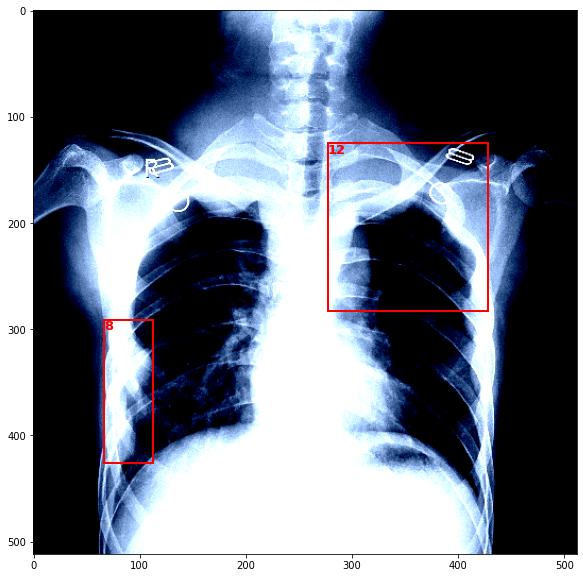

In [ ]:
import random
img, tar,_ = CDS[random.randint(0,100)]
bbox = tar['boxes'].numpy()
labels = tar['labels'].numpy()
fig,ax = plt.subplots(figsize=(18,10))
ax.imshow(img.permute(1,2,0).cpu().numpy())
for i in range(len(bbox)):
    box = bbox[i]
    x,y,w,h = box[0], box[1], box[2]-box[0], box[3]-box[1]
    rect = matplotlib.patches.Rectangle((x,y),w,h,linewidth=2,edgecolor='r',facecolor='none',)
    ax.text(*box[:2], labels[i], verticalalignment='top', color='red', fontsize=13, weight='bold')
    ax.add_patch(rect)
plt.show()

## leave only unique ids

In [ ]:
train_ids = train_df['image_id'].unique()
valid_ids = val_df['image_id'].unique()
train_df.shape,val_df.shape

((2974, 8), (722, 8))

## define train and val dataloaders

In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch))

train_dataset = XrayDataset(train_df,"img_dir" , get_to_v2_transform())
valid_dataset = XrayDataset(val_df,"img_dir", get_to_v2_transform())


# split the dataset in train and test set
indices = torch.randperm(len(train_dataset)).tolist()

train_data_loader = DataLoader(
    train_dataset,
    batch_size=4,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=4,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

## set device

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

## Model Faster RCNN pretrained 

In [ ]:
num_classes = len(train_df['class_id'].unique())+1  # 1 class (wheat) + background
# load a model; pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


## set model parameters

In [ ]:
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
#lr_scheduler = None

## define class for loss calculation

In [ ]:
class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        self.current_total  = 0.0
        self.iterations = 0.0

## test if model trains

In [ ]:
lr = 0.01
momentum = 0.9
isPr = True

model = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_320_fpn(pretrained=isPr)
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)


model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=lr, momentum=momentum, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
#lr_scheduler = None

loss_hist = Averager()
best_epoch = 0
min_loss = sys.maxsize
for epoch in range(num_epochs):
    loss_hist.reset()
    tk = tqdm(train_data_loader)
    for images, targets, image_ids in tk:
        
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        print("here")
        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()

        loss_hist.send(loss_value)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        
        history_data.append([loss_dict, losses, loss_value, epoch, lr, momentum, isPr])

        tk.set_postfix(train_loss=loss_value)
    tk.close()
    
    # update the learning rate
    if lr_scheduler is not None:
        lr_scheduler.step()

    print(f"Epoch #{epoch} loss: {loss_hist.value}") 
    
    if loss_hist.value<min_loss:
        print("Better model found at epoch {0} with {1:0.5f} loss value".format(epoch,loss_hist.value))
        torch.save(model.state_dict(), f"model_state_epoch_{epoch}.pth")
        min_loss = loss_hist.value
        best_epoch = epoch
        
model.load_state_dict(torch.load(f"./model_state_epoch_{best_epoch}.pth"));

here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here


here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here


# Grid Search

In [ ]:
num_epochs = 2
num_classes = len(train_df['class_id'].unique())+1  # 1 class (wheat) + background

## define hparams ranges for GridSearch

In [ ]:
learning_rates = [0.001, 0.005, 0.01]
momentums = [0.9, 0.95 ]
isPretrained = [False, True]

## preform GridSearch

In [ ]:
history_data = []
for lr in learning_rates:
  for momentum in momentums:
    for isPr in isPretrained:

      model = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_fpn(pretrained=isPr)
      # get number of input features for the classifier
      in_features = model.roi_heads.box_predictor.cls_score.in_features

      # replace the pre-trained head with a new one
      model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)


      model.to(device)
      params = [p for p in model.parameters() if p.requires_grad]
      optimizer = torch.optim.SGD(params, lr=lr, momentum=momentum, weight_decay=0.0005)
      lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
      #lr_scheduler = None

      loss_hist = Averager()
      best_epoch = 0
      min_loss = sys.maxsize
      for epoch in range(num_epochs):
          loss_hist.reset()
          tk = tqdm(train_data_loader)
          for images, targets, image_ids in tk:
              
              images = list(image.to(device) for image in images)
              targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

              loss_dict = model(images, targets)
              print("here")
              losses = sum(loss for loss in loss_dict.values())
              loss_value = losses.item()

              loss_hist.send(loss_value)

              optimizer.zero_grad()
              losses.backward()
              optimizer.step()
              
              history_data.append([loss_dict, losses, loss_value, epoch, lr, momentum, isPr])

              tk.set_postfix(train_loss=loss_value)
          tk.close()
          
          # update the learning rate
          if lr_scheduler is not None:
              lr_scheduler.step()

          print(f"Epoch #{epoch} loss: {loss_hist.value}") 
          
          if loss_hist.value<min_loss:
              print("Better model found at epoch {0} with {1:0.5f} loss value".format(epoch,loss_hist.value))
              torch.save(model.state_dict(), f"model_state_epoch_{epoch}.pth")
              min_loss = loss_hist.value
              best_epoch = epoch
              
      model.load_state_dict(torch.load(f"./model_state_epoch_{best_epoch}.pth"));

here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here

Epoch #0 loss: 1.6400297675231346
Better model found at epoch 0 with 1.64003 loss value


here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here

Epoch #1 loss: 0.767779392215837
Better model found at epoch 1 with 0.76778 loss value


Downloading: "https://download.pytorch.org/models/fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth


here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here

Epoch #0 loss: 0.9387298397698067
Better model found at epoch 0 with 0.93873 loss value


here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here

Epoch #1 loss: 0.5824337788545185
Better model found at epoch 1 with 0.58243 loss value


here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here

Epoch #0 loss: 1.6627357475608557
Better model found at epoch 0 with 1.66274 loss value


here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here

Epoch #1 loss: 0.8534517503078798
Better model found at epoch 1 with 0.85345 loss value


here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here

Epoch #0 loss: 0.9097546984496809
Better model found at epoch 0 with 0.90975 loss value


here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here

Epoch #1 loss: 0.49251023876438793
Better model found at epoch 1 with 0.49251 loss value


here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here

Epoch #0 loss: 1.1454160139047689
Better model found at epoch 0 with 1.14542 loss value


here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here

Epoch #1 loss: 0.409101012580348
Better model found at epoch 1 with 0.40910 loss value


here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here

Epoch #0 loss: 0.7307472062772862
Better model found at epoch 0 with 0.73075 loss value


here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here

Epoch #1 loss: 0.5913069073816621
Better model found at epoch 1 with 0.59131 loss value


here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here

Epoch #0 loss: 1.1976093757766657
Better model found at epoch 0 with 1.19761 loss value


here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here

Epoch #1 loss: 0.3974112702085267
Better model found at epoch 1 with 0.39741 loss value


here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here

Epoch #0 loss: 0.7185446293937224
Better model found at epoch 0 with 0.71854 loss value


here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here

Epoch #1 loss: 0.5821691718664704
Better model found at epoch 1 with 0.58217 loss value


here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here

Epoch #0 loss: nan


here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here

Epoch #1 loss: nan


here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here

Epoch #0 loss: nan


here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here

Epoch #1 loss: nan


here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here

Epoch #0 loss: 267.8769484637455
Better model found at epoch 0 with 267.87695 loss value


here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here

Epoch #1 loss: nan


here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here

Epoch #0 loss: 0.6782846960352996
Better model found at epoch 0 with 0.67828 loss value


here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here

Epoch #1 loss: 0.5565190813129759
Better model found at epoch 1 with 0.55652 loss value


In [ ]:
hd = np.array(history_data  )

In [ ]:
np.save("gs_hist_full.npy",hd )

## Process history and find best hparams
## cross validation results for train_val_limit = 10
- fasterrcnn_resnet50_fpn, best model's hparams: ([1, 0.005, 0.95, False], 0.1531658501887338)
- fasterrcnn_mobilenet_v3_large_320_fpn, best model's hparams:  ([1, 0.01, 0.9, True], 0.10890237162157312)
- fasterrcnn_mobilenet_v3_large_fpn, best model's hparams: ([1, 0.001, 0.95, True], 0.18153923258297036)

In [ ]:
lowest_loss = 10
best_params = [] #[loss_dict, losses, loss_value, epoch, lr, momentum, isPr])
for line in history_data:
  loss_epoch = 0
  batch_count = 0
  for lr in learning_rates:
    for momentum in momentums:
      for isPr in isPretrained:
        for epoch in range(num_epochs):
          [epoch_, lr_, momentum_, isPr_] = line[3:]
          if (epoch==epoch_) and (lr==lr_) and (momentum==momentum_) and (isPr==isPr_):
            batch_count += 1
            loss_epoch += line[2]
  loss_epoch /= batch_count
  if (loss_epoch < lowest_loss):
    lowest_loss = line[2]
    best_params = line[3:]
best_params, lowest_loss           

([1, 0.001, 0.95, True], 0.18153923258297036)

## plot training results for best model

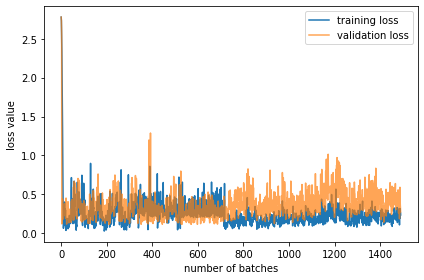

In [ ]:
import matplotlib.pyplot as plt
import math

#([loss_dict, losses, loss_value, epoch, lr, momentum, isPr])
loss_classifier = []
loss_box_reg = []
loss_objectness = []
loss_rpn_box_reg = []
loss_values = []
for line in history_data:
  loss_classifier.append(line[0]['loss_classifier'].detach().cpu().numpy())
  loss_box_reg.append(line[0]['loss_box_reg'].detach().cpu().numpy())
  loss_objectness.append(line[0]['loss_objectness'].detach().cpu().numpy())
  loss_rpn_box_reg.append(line[0]['loss_rpn_box_reg'].detach().cpu().numpy())
  loss_values.append(line[2])
 
fig, ax = plt.subplots()
ax.plot(loss_classifier)
ax.plot(loss_box_reg, alpha=0.7)
ax.set_xlabel("number of batches")
ax.set_ylabel("loss value")
ax.legend(["training loss", "validation loss"])
fig.tight_layout()
fig.savefig("Training and val loss for best frcnn model fasterrcnn_mobilenet_v3_large_320_fpn.png")
#ax.plot(loss_objectness)
#ax.plot(loss_rpn_box_reg)

# Post processing labels

## apply_nms function

Source : https://pytorch.org/vision/stable/ops.html

In [ ]:
model.load_state_dict(torch.load('../input/vinbigdata-abnormalities-detection-imgx512/model_state_epoch_12.pth'));

In [ ]:
# the function takes the original prediction and the iou threshold.
def apply_nms(orig_prediction, iou_thresh=0.3):
    
    # torchvision returns the indices of the bboxes to keep
    keep = torchvision.ops.nms(orig_prediction['boxes'], orig_prediction['scores'], iou_thresh)
    
    final_prediction = orig_prediction
    final_prediction['boxes'] = final_prediction['boxes'][keep]
    final_prediction['scores'] = final_prediction['scores'][keep]
    final_prediction['labels'] = final_prediction['labels'][keep]
    
    return final_prediction

# make predictions

## take a sample from valid dataset and make Prediction

In [ ]:
submission = pd.read_csv('../input/vinbigdata-chest-xray-abnormalities-detection/sample_submission.csv')

In [ ]:
ts_ids = submission.image_id.unique().tolist()

In [ ]:
TCDS = TestDataset(submission,ts_img_dir2,get_test_transform())

In [ ]:
img,_,_,_ = TCDS[0]

In [ ]:
test_data_loader = DataLoader(
    TCDS,
    batch_size=8,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

## Prediction on Test Set

In [ ]:
results = []

with torch.no_grad():

    for images, image_ids,_,_ in tqdm(test_data_loader):

        images = list(image.to(device) for image in images)
        outputs = model(images)
        results.append(outputs)

  0%|          | 0/375 [00:00<?, ?it/s]

In [ ]:
img,target,_ = valid_dataset[58]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])[0]
    
print('predicted #boxes: ', len(prediction['labels']))
print('real #boxes: ', len(target['labels']))

predicted #boxes:  94
real #boxes:  1


## Plotting Predictions

In [ ]:
def plot_valid(img,prediction,nms=True,detect_thresh=0.5,iou_thresh=0.2):
    '''
    img = val_image
    nms = use non maximum-supression 
    prediction dict
    detection threshold
    intersection over union threshold for non-maximum suppression (NMS)
    '''
    fig,ax = plt.subplots(figsize=(8,8))
    val_img = img.permute(1,2,0).cpu().detach().numpy()
    ax.imshow(val_img)
    nms_prediction = apply_nms(prediction, iou_thresh=iou_thresh) if nms else prediction
    val_scores = nms_prediction['scores'].cpu().detach().numpy()
    bbox = nms_prediction['boxes'].cpu().detach().numpy()
    lbls = nms_prediction['labels'].cpu().detach().numpy()
    for i in range(len(bbox)):
        if val_scores[i]>=detect_thresh:
            box = bbox[i]
            x,y,w,h = box[0], box[1], box[2]-box[0], box[3]-box[1]
            rect = matplotlib.patches.Rectangle((x,y),w,h,linewidth=2,edgecolor='r',facecolor='none',)
            ax.text(*box[:2], "Class {0} | {1:.3f}".format(lbls[i],val_scores[i]), verticalalignment='top', color='white', fontsize=12, weight='bold')
            ax.add_patch(rect)
    plt.show()

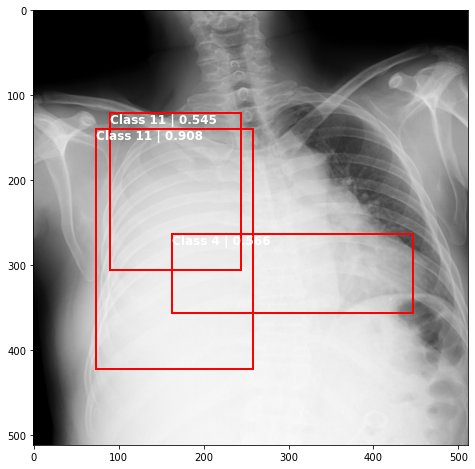

In [ ]:
plot_valid(img,prediction,False)

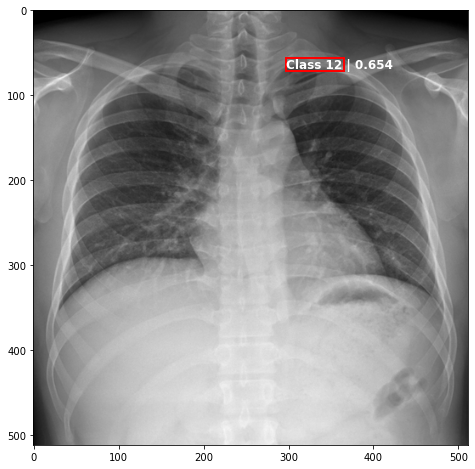

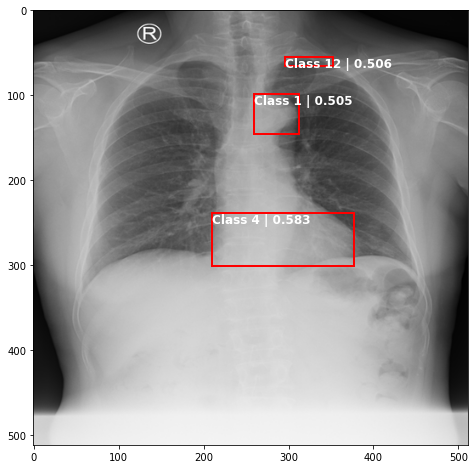

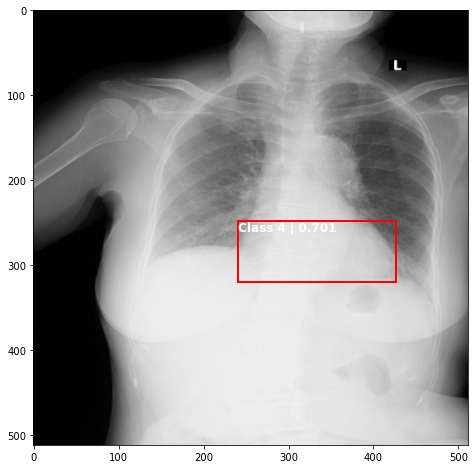

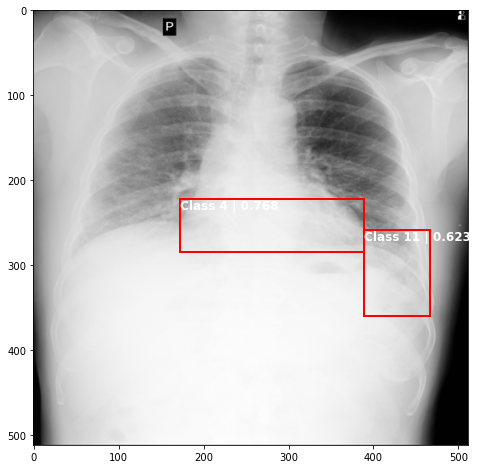

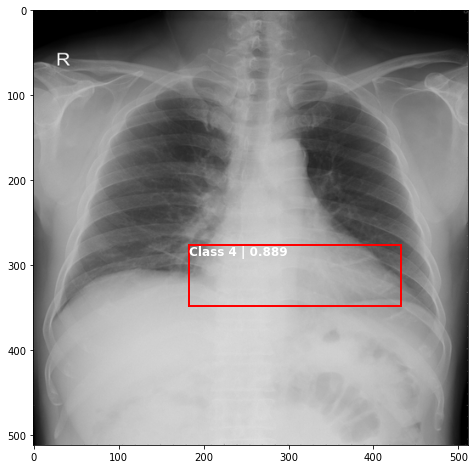

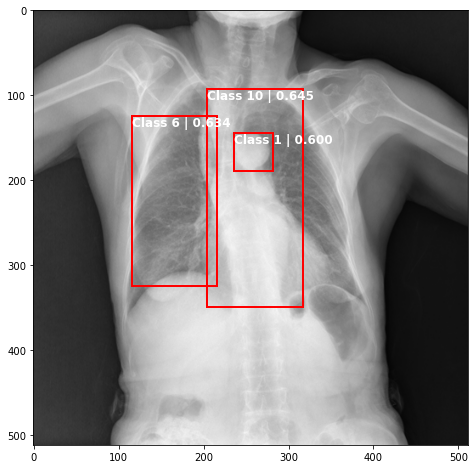

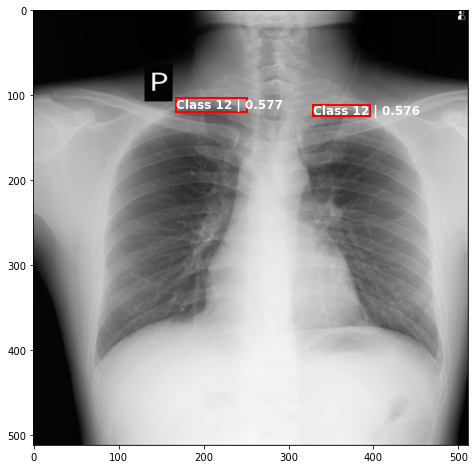

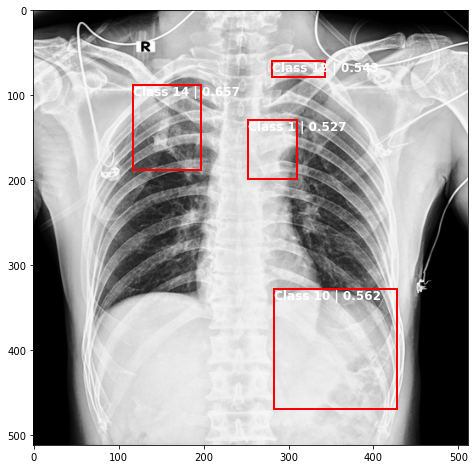

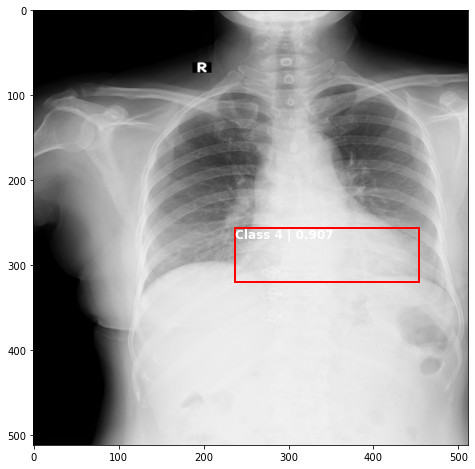

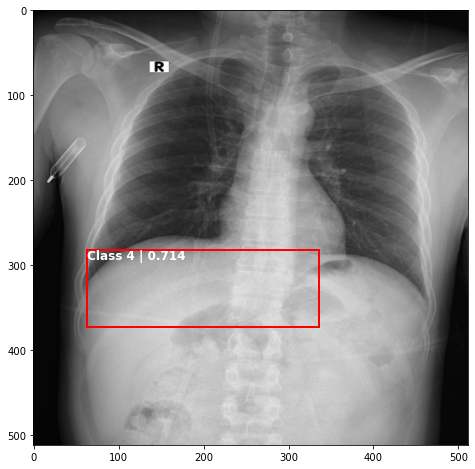

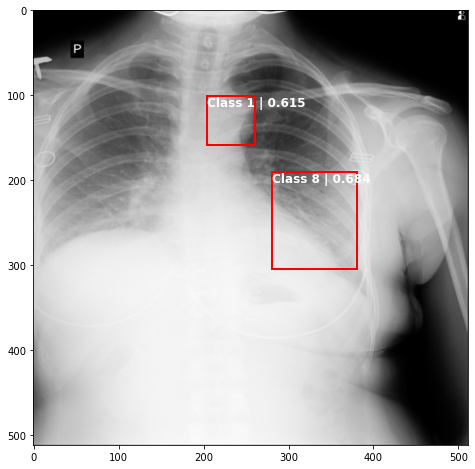

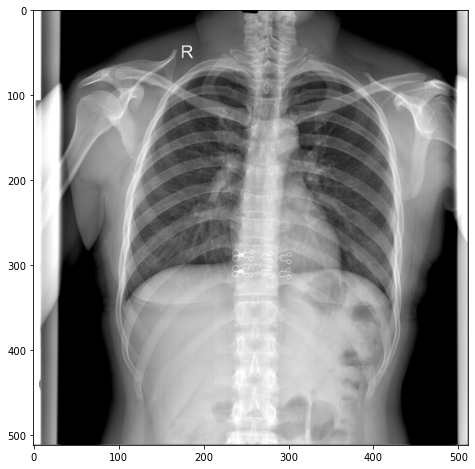

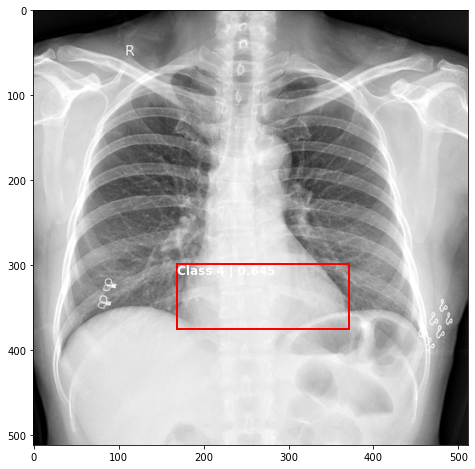

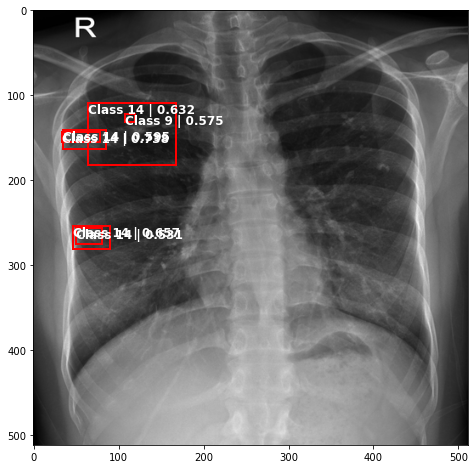

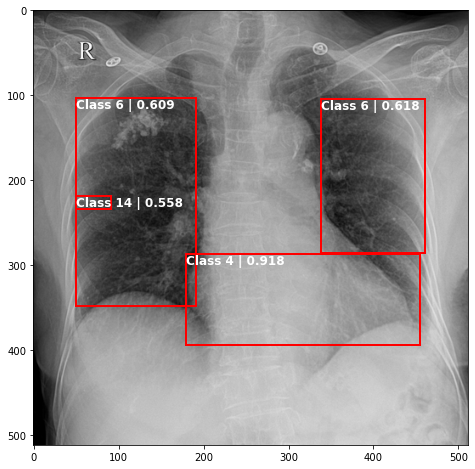

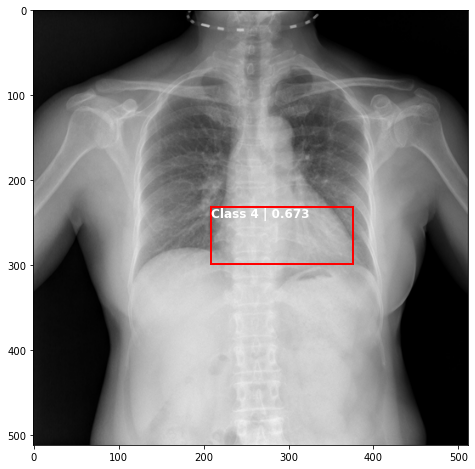

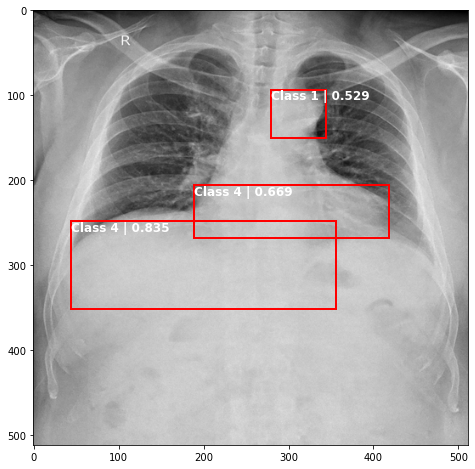

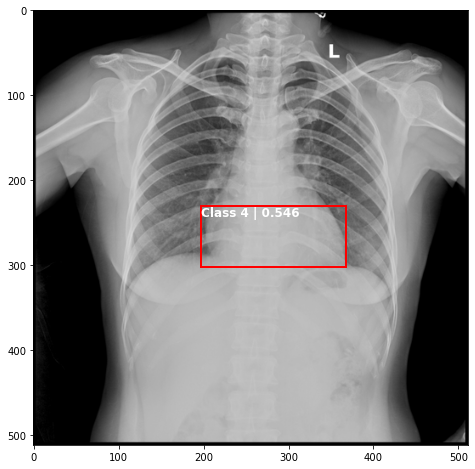

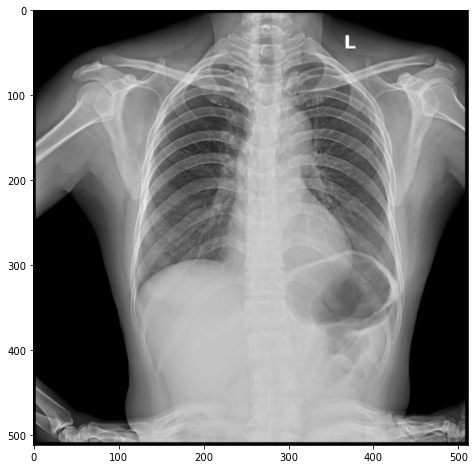

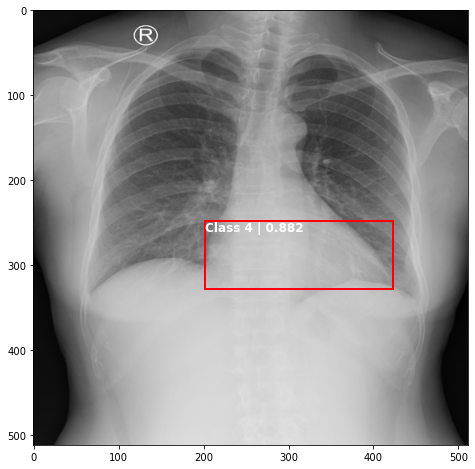

In [ ]:
j = -1
for i in range(20):
    if i%8==0:
        j+=1
    ts_img,_,_,_ = TCDS[i]
    plot_valid(ts_img,results[j][i%8],False)

In [ ]:
# prevent notebook from disconnection
while True: pass